# 4b) Build Complete Localization Map
Building the map involves the **precomputation** of all the **global descriptors** (necessary for image retrieval), **keypoints** (essential for accurate pose estimation), **matches** between keypoints, **3D points** and **camera poses** in unique coordiante system. We begin by loading the required modules..

In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path

from hloc import (
    extract_features,
    match_features,
    reconstruction,
    visualization,
    pairs_from_retrieval,
)
from hloc.utils import viz_3d

## Setup
We will run SfM (Structure from Motion) reconstruction from scratch on a set of images. The intrinsic parameters will be extracted from the EXIF data and refined with SfM. First, we define some paths.

In [2]:
images = Path("/data/grenoble/images/db")
outputs = Path("/data/outputs/grenoble_sfm/")

global_descriptor = "senet"           # dir, netvlad, openibl, eigenplaces, senet
keypoints_detector = "disk"           # sift, superpoint_aachen, superpoint_inloc, superpoint_max, r2d2, d2net-ss, sosnet, disk
keypoints_matcher = "disk+lightglue"  # NN-mutual, NN-ratio, adalam, NN-superpoint, superglue-fast, superglue, superpoint+lightglue 

### [Optional] Download the Dataset
We can either choose the localization on our floor or use the [South-Building dataset](https://openaccess.thecvf.com/content_cvpr_2013/html/Hane_Joint_3D_Scene_2013_CVPR_paper.html).

In [3]:
# images = Path("/data/South-Building/images/")
# outputs = Path("/data/outputs/South-Building/")

#if not images.exists():
#    !wget https://cvg-data.inf.ethz.ch/local-feature-evaluation-schoenberger2017/South-Building.zip -P data/
#    !unzip -q data/South-Building.zip -d data/

In [4]:
sfm_pairs = outputs / (f"pairs-{global_descriptor}.txt")
sfm_dir = outputs / (f"sfm_{keypoints_matcher}")

retrieval_conf = extract_features.confs[global_descriptor]
feature_conf = extract_features.confs[keypoints_detector]
matcher_conf = match_features.confs[keypoints_matcher]

## [OFFLINE] Find image pairs via image retrieval
We extract global descriptors with NetVLAD and find for each image the most similar ones. For smaller dataset we can instead use exhaustive matching via `hloc/pairs_from_exhaustive.py`, which would find $\frac{n(n-1)}{2}$ images pairs.

In [5]:
retrieval_path = extract_features.main(retrieval_conf, images, outputs)
pairs = pairs_from_retrieval.main(retrieval_path, sfm_pairs, num_matched=5)

[2024/02/08 21:11:59 hloc INFO] Extracting local features with configuration:
{'model': {'model_name': 'SENet_R50_con',
           'name': 'senet',
           'resnet_size': 50,
           'scale_list': [0.7071, 1.0, 1.4142]},
 'output': 'global-feats-senet',
 'preprocessing': {'resize_max': 1024}}
[2024/02/08 21:11:59 hloc INFO] Found 24 images in root /data/grenoble/images/db.
100%|██████████████████████████████████████████████████████████| 24/24 [00:26<00:00,  1.09s/it]
[2024/02/08 21:12:26 hloc INFO] Finished exporting features.
[2024/02/08 21:12:26 hloc INFO] Extracting image pairs from a retrieval database.
[2024/02/08 21:12:26 hloc INFO] Found 120 pairs.


## [OFFLINE] Extract and match local features (keypoints)

In [6]:
feature_path = extract_features.main(feature_conf, images, outputs)
match_path = match_features.main(
    matcher_conf, sfm_pairs, feature_conf["output"], outputs
)

[2024/02/08 21:13:02 hloc INFO] Extracting local features with configuration:
{'model': {'max_keypoints': 5000, 'name': 'disk'},
 'output': 'feats-disk',
 'preprocessing': {'grayscale': False, 'resize_max': 1600}}
[2024/02/08 21:13:02 hloc INFO] Found 24 images in root /data/grenoble/images/db.
100%|██████████████████████████████████████████████████████████| 24/24 [00:36<00:00,  1.50s/it]
[2024/02/08 21:13:38 hloc INFO] Finished exporting features.
[2024/02/08 21:13:38 hloc INFO] Matching local features with configuration:
{'model': {'features': 'disk', 'name': 'lightglue'},
 'output': 'matches-disk-lightglue'}
100%|██████████████████████████████████████████████████████████| 72/72 [02:48<00:00,  2.35s/it]
[2024/02/08 21:16:28 hloc INFO] Finished exporting matches.


## [OFFLINE] Incremental SfM
Run COLMAP on the features and matches.

In [23]:
model = reconstruction.main(sfm_dir, images, sfm_pairs, feature_path, match_path)

Reconstruction exists. Recompute (R) or Load (L)? [R/L]:  L


[2024/02/08 11:40:31 hloc INFO] Loaded existing reconstruction from outputs/grenoble_sfm/sfm_superpoint+superglue


In [24]:
print(model)

Reconstruction(num_reg_images=24, num_cameras=1, num_points3D=15389, num_observations=51214)

## Visualization
We visualize some of the registered images, and color their keypoint by visibility, track length, or triangulated depth.

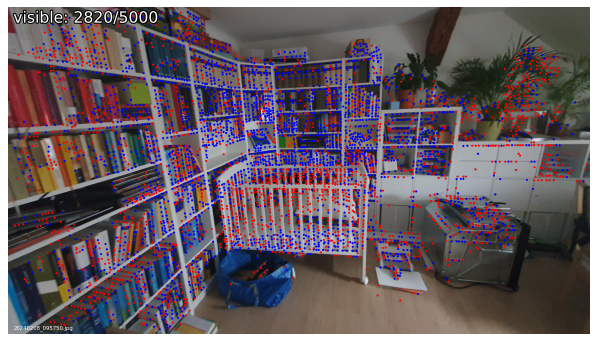

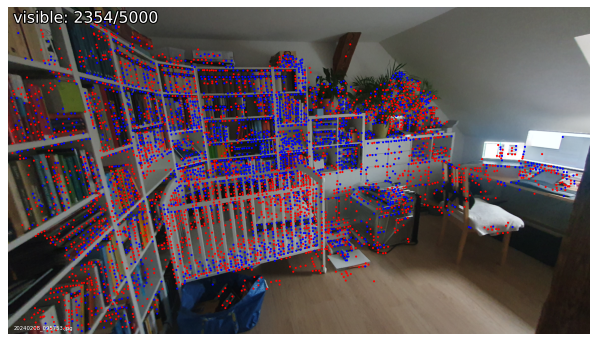

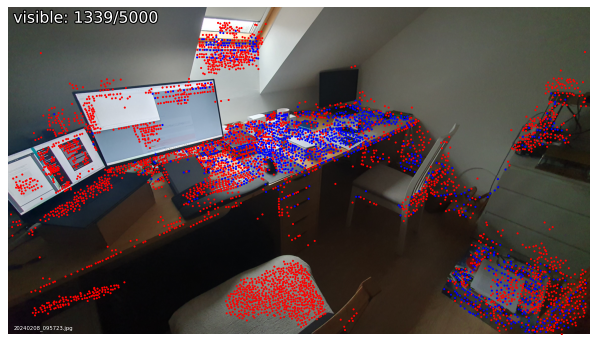

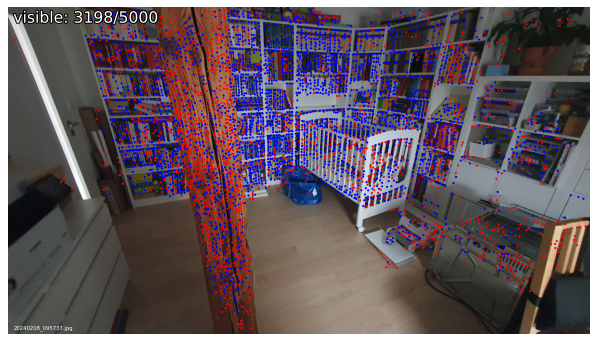

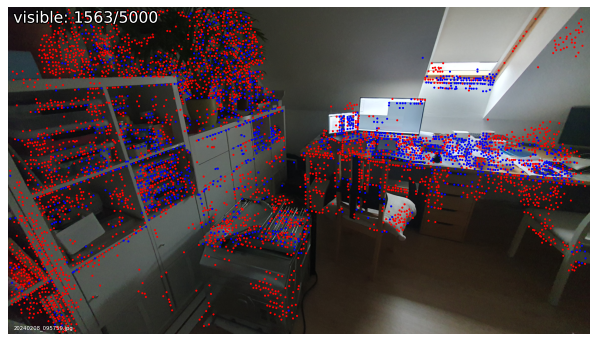

In [25]:
visualization.visualize_sfm_2d(model, images, color_by="visibility", n=5)

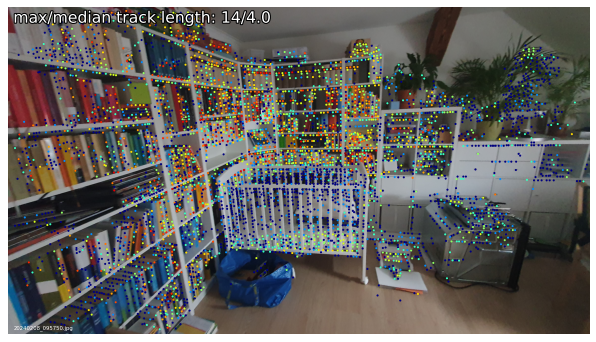

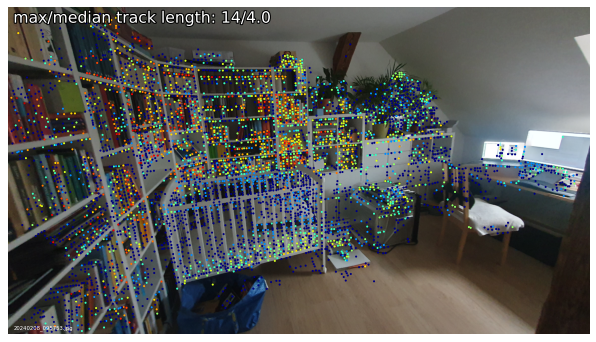

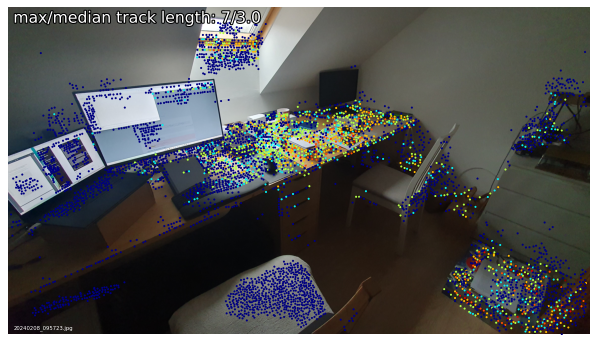

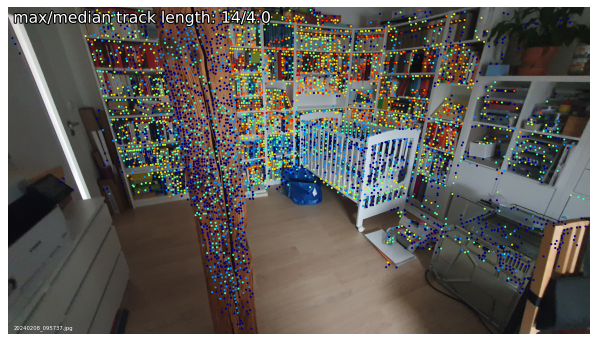

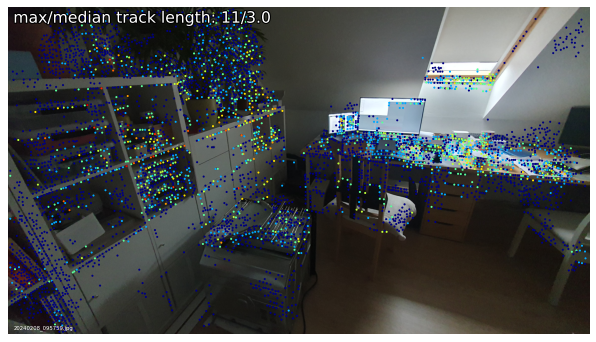

In [26]:
visualization.visualize_sfm_2d(model, images, color_by="track_length", n=5)

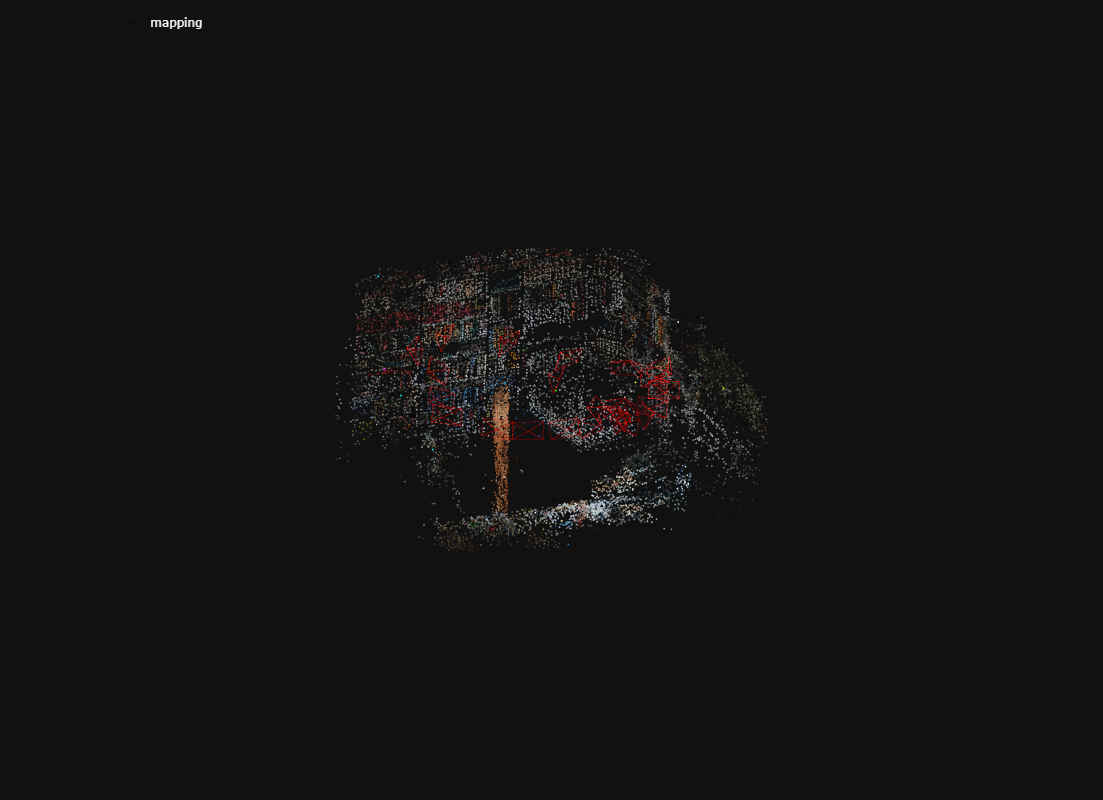

In [27]:
fig = viz_3d.init_figure()
viz_3d.plot_reconstruction(
    fig, model, color="rgba(255,0,0,0.5)", name="mapping", points_rgb=True
)
fig.show()